In [341]:
# Magnetic moment classifier using SVM
# https://arxiv.org/abs/1806.07989

In [342]:
import warnings
warnings.filterwarnings('ignore')

In [369]:
import itertools
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from tqdm.notebook import tqdm

In [370]:
print(os.listdir('../datasets'))

['.DS_Store', 'datatrain.csv', 'datatest.csv', 'magneticmoment_Ef_data.csv']


In [371]:
df_train = pd.read_csv('../datasets/datatrain.csv')
df_test = pd.read_csv('../datasets/datatest.csv')

X_train = df_train.drop(['structure', 'class'], axis=1)
selected_train = df_train[['m1', 'm2', 'mtot', 'fermi', 'nelectrons']]
y_train = df_train['class'].values

X_test = df_test.drop(['structure', 'class'], axis=1)
selected_test = df_test[['m1', 'm2', 'mtot', 'fermi', 'nelectrons']]
y_test = df_test['class'].values

In [372]:
X_train.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,m6,m7,m8,m9,m10,mtot,fermi,band,toten,nelectrons
0,3.11426,1.79802,11.54446,6.22852,3.59604,11.54424,-0.0,-0.0,10.34873,-0.0,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-3.158349,-483.374457,-40.380609,62.0
1,3.38614,1.95499,11.00558,6.77228,3.90998,11.00853,0.0,-0.0,9.86708,0.0,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-1.873443,-379.251497,-35.261134,62.0
2,3.11492,1.79840,10.62429,6.22985,3.59680,10.62447,-0.0,0.0,9.51753,-0.0,...,0.044,0.061,0.015,0.010,0.013,0.547,-2.335318,-482.074122,-41.354746,63.0
3,3.39551,1.96040,10.40155,6.79103,3.92081,10.40574,-0.0,-0.0,9.32076,-0.0,...,0.034,0.040,0.005,0.011,0.004,0.524,-1.352459,-389.016012,-36.503814,63.0
4,3.08785,1.78277,10.83735,6.17572,3.56555,10.83811,-0.0,-0.0,9.72958,0.0,...,0.000,0.000,0.000,0.000,0.000,-0.000,-3.043384,-472.035630,-41.755620,62.0


In [373]:
selected_train.head()

,m1,m2,mtot,fermi,nelectrons
0,0.000,0.000,0.000,-3.158349,62.0
1,0.000,0.000,0.000,-1.873443,62.0
2,0.142,0.142,0.547,-2.335318,63.0
3,0.177,0.177,0.524,-1.352459,63.0
4,-0.000,-0.000,-0.000,-3.043384,62.0


In [374]:
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# PCA with all features
X_transformed = pca.fit_transform(X_train)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca = pd.DataFrame(data=X_transformed, columns=columns)
df_pca = pd.concat([df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_train['class']], axis = 1)

# PCA with selected features
selected_transformed = pca2.fit_transform(selected_train)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca2 = pd.DataFrame(data=selected_transformed, columns=columns)
df_pca2 = pd.concat([df_pca2['Principal Component 1'], df_pca2['Principal Component 2'], df_train['class']], axis = 1)

In [375]:
print('PCA with all features variance ratio:      {}'.format(pca.explained_variance_ratio_))
print('PCA with selected features variance ratio: {}'.format(pca2.explained_variance_ratio_))

PCA with all features variance ratio:      [0.97681448 0.01741144]
PCA with selected features variance ratio: [0.94642227 0.03696009]


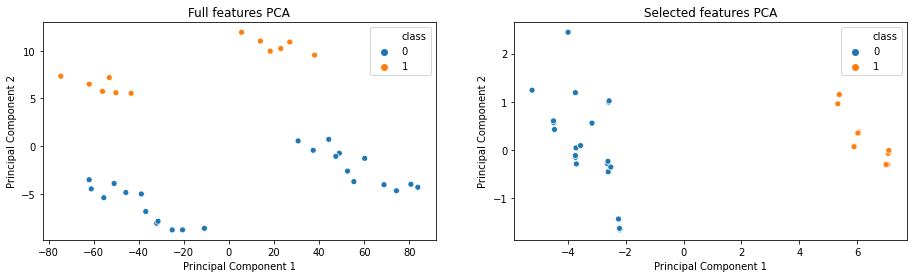

In [376]:
fig, ax =plt.subplots(1,2)
ax[0].set_title('Full features PCA')
ax[1].set_title('Selected features PCA')
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[0])
sns.scatterplot(data=df_pca2, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[1])
plt.subplots_adjust(left=2, right=4)
fig.show()

In [377]:
pipe = [('pca', PCA()), ('classifier', SVC())]
param_grid = {
    'pca__n_components': [2],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__C': [0.1, 0.5, 1, 10, 30, 40, 50, 70, 100, 500, 1000],
    'classifier__gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe)

In [378]:
test_transformed = pca.transform(X_test)

print('Tuning SVM hyperparameters with full features used')
for n in tqdm(range(4, 9)):
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=KFold(n_splits=n))
    grid.fit(X_transformed, y_train)
    print('Score for {} KFold: {}%'.format(n, grid.score(test_transformed, y_test) * 100))
    print(grid.best_params_)
    print()

Tuning SVM hyperparameters with full features used


Score for 4 KFold: 93.75%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 5 KFold: 93.75%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 6 KFold: 93.75%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 7 KFold: 93.75%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 8 KFold: 93.75%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}




In [379]:
test_transformed2 = pca2.transform(selected_test)

print('Tuning SVM hyperparameters with only selected features')
for n in tqdm(range(4, 9)):
    grid2 = GridSearchCV(pipeline, param_grid=param_grid, cv=KFold(n_splits=n))
    grid2.fit(selected_transformed, y_train)
    print('Score for {} KFold: {}%'.format(n, grid2.score(test_transformed2, y_test) * 100))
    print(grid2.best_params_)
    print()

Tuning SVM hyperparameters with only selected features


Score for 4 KFold: 100.0%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 5 KFold: 100.0%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 6 KFold: 100.0%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 7 KFold: 100.0%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}

Score for 8 KFold: 100.0%
{'classifier__C': 0.1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'linear', 'pca__n_components': 2}




In [380]:
clf = SVC(kernel=grid.best_params_['classifier__kernel'],
          gamma=grid.best_params_['classifier__gamma'],
          C=grid.best_params_['classifier__C'])
clf.fit(X_transformed, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [381]:
y_pred = clf.predict(test_transformed)
print('SVM Accuracy with best params: {}%'.format(accuracy_score(y_pred, y_test) * 100))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred))

SVM Accuracy with best params: 93.75%
Actual test label:    [0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0]


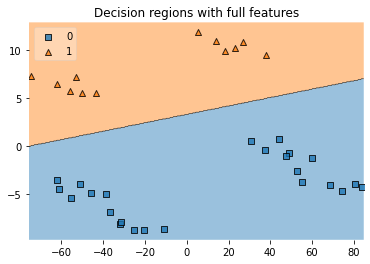

In [382]:
plt.title('Decision regions with full features')
plot_decision_regions(X_transformed, y_train, clf=clf, legend=2)

In [383]:
clf2 = SVC(kernel=grid2.best_params_['classifier__kernel'],
          gamma=grid2.best_params_['classifier__gamma'],
          C=grid2.best_params_['classifier__C'])
clf2.fit(selected_transformed, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [384]:
y_pred2 = clf2.predict(test_transformed2)
print('SVM Accuracy with best params: {}%'.format(accuracy_score(y_pred2, y_test) * 100))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred2))

SVM Accuracy with best params: 100.0%
Actual test label:    [0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]


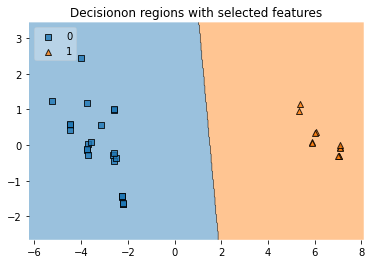

In [385]:
plt.title('Decisionon regions with selected features')
plot_decision_regions(selected_transformed, y_train, clf=clf2, legend=2)

In [386]:
rfe = RFE(estimator=clf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

print('Chosen best 5 features by RFE: {}'.format(X_train.columns[rfe.support_]))

Chosen best 5 features by RFE: Index(['m1', 'm2', 'mtot', 'fermi', 'nelectrons'], dtype='object')


In [387]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

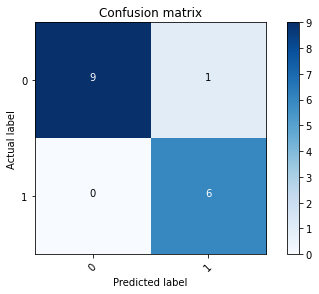

In [388]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, [0, 1])

In [389]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.86      1.00      0.92         6

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



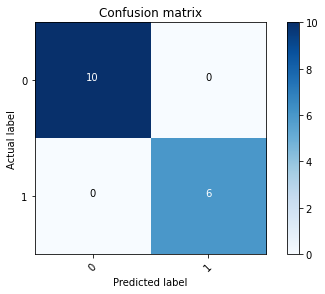

In [390]:
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cm2, [0, 1])

In [391]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         6

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



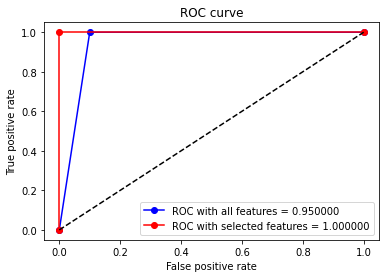

In [392]:
# All features
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Selected features
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr, tpr, 'bo-', label='ROC with all features = %f' %roc_auc)
plt.plot(fpr2, tpr2, 'ro-', label='ROC with selected features = %f' %roc_auc2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()